In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from autoencoder import AutoEncoder, VariationalAutoEncoder, LSTMAutoEncoder
import resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import PurePosixPath as Path
from tensorflow.keras.models import Model

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/tomje/miniconda3/envs/tf/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Load in RMS data for tests

In [2]:
exps = ['Test 5', 'Test 7', 'Test 8', 'Test 9']
# exps = ['Test 5']
rms = {}

for test in exps:
    rms[test] = resources.ae.RMS(test)
    rms[test].data.drop(['0', '1', '2',], axis=1, inplace=True)
    
try:
    rms['Test 5'].data.drop(['23', '24'], axis=1, inplace=True)
except KeyError:
    pass

--------------------------------------------------
Loaded RMS data for "22_08_03_grit1000"
Experiemnt No: Test 5
Number of files: 213
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_07_weartest_1000"
Experiemnt No: Test 7
Number of files: 163
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_09_weartest_1000"
Experiemnt No: Test 8
Number of files: 176
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_30_weartest_1000"
Experiemnt No: Test 9
Number of files: 158
--------------------------------------------------


In [3]:
def remove_dc(sig):
    return sig - np.nanmean(sig)

for test in exps:
    rms[test]._data = rms[test].data.iloc[50:350, :].reset_index(drop=True)
    rms[test]._data = rms[test].data.apply(remove_dc, axis=0)

In [22]:
# Join 3 datasets for transfer learning
# training section is going to be first 70 cuts of each test

dfs = [rms[test].data.iloc[:, :70].values for test in exps[:-1]]
join_df = np.concatenate(dfs, axis=1)
join_df = pd.DataFrame(join_df)
print(np.shape(join_df))

# Create RMS obj for the join_df data
class join_rms_obj:
    def __init__(self, data, exp_name):
        self.data = data
        self.exp_name = exp_name

join_rms = join_rms_obj(join_df, 'join_df')
exps = ['join_rms']

(300, 210)


In [ ]:
r = rms[test].data.values
r.shape
plt.plot(r[:, 43])
plt.xlabel('Samples')
plt.ylabel('Rolling RMS (V)')
plt.autoscale(enable=True, axis='x', tight=True)
# plt.plot(r[:, 120])
# plt.plot(r[:, 145])

# Setup Autoencoder for each Test
- The model is trained over a small section of the test depending on `train_slice`.
- The model parameters are specified within the `params` dict.

In [31]:
autoe = {}
for test in exps:
        """
        autoe[test] = VariationalAutoEncoder(rms[test],
                                             rms[test].data,
                                             tb=False,
                                             tb_logdir=rms[test].exp_name,
                                             train_slice=(0, 75),
                                             val_frac=0.33,
                                             params={'latent_dim': 4,
                                                   'n_size': [64, 32],
                                                   'epochs': 1000,
                                                   'batch_size': 15,
                                                   'callbacks': [
                                                           tf.keras.callbacks.EarlyStopping(
                                                                monitor='val_loss',
                                                                patience=60,
                                                                mode='min',
                                                                start_from_epoch=100,
                                                           ),
                                                        ]
                                                   }
                                           )
        """
        '''
        autoe[test] = AutoEncoder(rms[test],
                                  rms[test].data,
                                  tb=False,
                                  tb_logdir=rms[test].exp_name.upper().replace(' ', '_'),
                                  train_slice=(0, 50),
                                  val_frac=0.33,
                                  random_state=2,
                                  params={'n_bottleneck': 9,
                                          'n_size': [42, 32, 16],
                                          'epochs': 1000,
                                          'batch_size': 40,
                                          'loss': 'mse',
                                          'callbacks': [
                                                  tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=80,
                                                              mode='min',
                                                              start_from_epoch= 150,
                                                  ),
                                                #   tf.keras.callbacks.ReduceLROnPlateau(
                                                #                 monitor='val_loss',
                                                #                 mode='min',
                                                #                 patience=25,
                                                #                 factor=0.01,
                                                #   ),
                                                ]

                                          }
                                  )                                
        '''
        autoe[test] = LSTMAutoEncoder(join_rms,
                                      join_rms.data,
                                      tb=True,
                                      tb_logdir='LSTMAE_test',
                                      train_slice=(0, 209),
                                      val_frac=0.33,
                                      params={'epochs': 300,
                                              'batch_size': 64,
                                              'n_size': [256, 128, 64],
                                              'seq_len': 100,
                                              'n_bottleneck': 32,
                                              'loss': 'mean_squared_error',
                                              'callbacks': [
                                                      tf.keras.callbacks.EarlyStopping(
                                                        monitor='val_loss',
                                                        patience=10,
                                                        mode='min',
                                                        start_from_epoch= 150,
                                                        ),
                                                 ]
                                      }
                                )

Pre-processing Data:
	Combining RMS data...
	Number of RMS samples: (63000, 1)

	Training Data: slice(0, 209, None)
	Input train shape: (42009, 1)
	Input val shape: (20691, 1)

LSTMAE-join_df-WIN-100-E-300-L-[256, 128, 64, 32, 64, 128, 256]-20230728-110713



In [32]:
platform = os.name
if platform == 'nt':
    onedrive = Path(r'C:\Users\tomje\OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
elif platform == 'posix':
    onedrive = Path(r'/mnt/c/Users/tomje/OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
print(TB_DIR)

/mnt/c/Users/tomje/OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard


In [33]:
# add model checkpoint callback after creating model
for test in exps:
    name = autoe[test].run_name
    model_folder = TB_DIR.joinpath(autoe[test]._tb_logdir.joinpath(name))
    if not os.path.exists(model_folder):
       os.makedirs(model_folder)
    assert os.path.exists(model_folder)

    autoe[test].model.callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
        filepath=model_folder.joinpath(f'{name}.h5'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
        )
    )

# Train each autoe on the training data
- `x` is the inputted data for training, which is `autoe.train_data`
- `val_data` is the validation data from `autoe.val_data`

In [35]:
for test in exps:
        autoe[test].fit(x=autoe[test].train_data,
                        val_data=autoe[test].val_data,
                        verbose=0,
                        use_multiprocessing=True,
                        )

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

## Reload saved weights from best model

In [36]:
for test in exps:
    name = autoe[test].run_name
    model_folder = TB_DIR.joinpath(autoe[test]._tb_logdir.joinpath(name))
    autoe[test].model.model_.load_weights(
        TB_DIR.joinpath(model_folder.joinpath(f'{name}.h5'),),
    )
    autoe[test].pred = None
    autoe[test].scores = None

# Results Visualisation

## Loss plot of each trained model

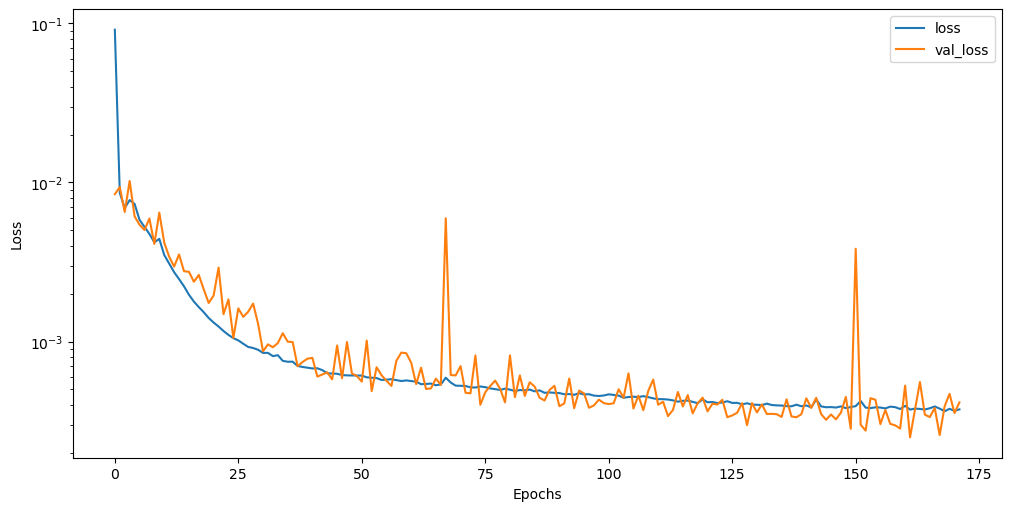

In [37]:
fig, ax = plt.subplots(1, len(exps),
                       figsize=(10,5),
                       constrained_layout=True,
                       )
# ax = ax.ravel()
for i, test in enumerate(exps):
    axis = fig.axes[i]
    autoe[test].loss_plot(plt_ax=axis)
    axis.set_yscale('log')
    if i > 0:
        axis.set_ylabel('')

## Score each model
- Models scored on train, validation and whole dataset

In [38]:
for test in exps:
    autoe[test].scores = None
    autoe[test].pred = None

In [39]:
for test in exps:
    print(f'\n {test}')
    pred_tr, scores_tr = autoe[test].score('train')
    pred_val, scores_val = autoe[test].score('val')
    pred_data, scores_data = autoe[test].score('dataset')


 join_rms

Predicting data:
983/983 [==============================] - 228s 230ms/step

Train Scores:
	MAE: 0.01195
	MSE: 0.00024
	R2: 0.96396

Predicting data:

Val Scores:
	MAE: 0.01206
	MSE: 0.00025
	R2: 0.96352

Predicting data:

Dataset Scores:
	MAE: 0.01198
	MSE: 0.00025
	R2: 0.96379


## Show histogram of scores across training dataset

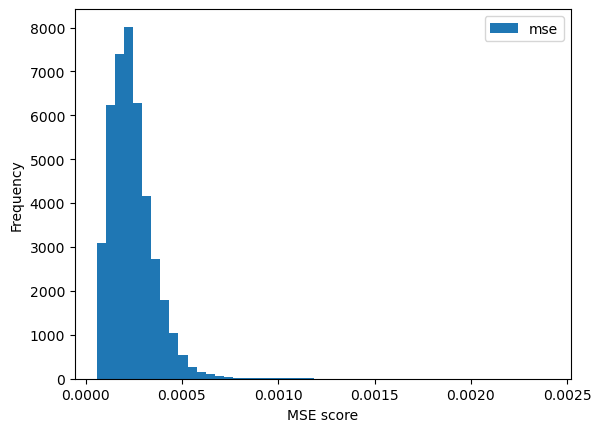

In [40]:
for test in exps:
    fig, ax = autoe[test].hist_scores(['mse'])

## Show model recreation capability of training and validation sets

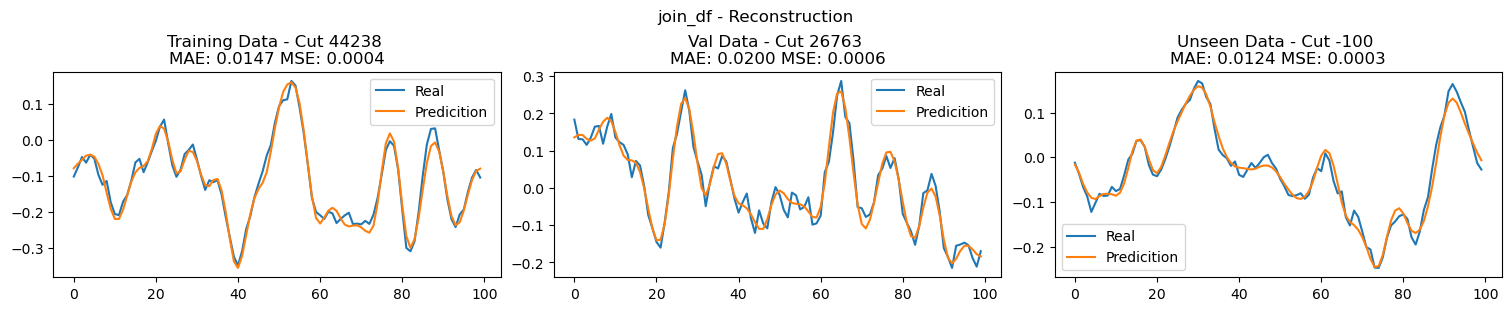

In [41]:
for test in exps:
    fig, ax = plt.subplots(1, 3, figsize=(15,3), constrained_layout=True)
    fig.suptitle(f'{autoe[test].RMS.exp_name} - Reconstruction')
    ax = ax.ravel()

    # Training plot
    ax[0] = autoe[test].pred_plot(autoe[test]._ind_tr[0], plt_ax=ax[0])
    ax[0].set_title(f'Training Data - Cut {autoe[test]._ind_tr[0]} \n{ax[0].get_title()}')

    # Validation plot
    ax[1] = autoe[test].pred_plot(autoe[test]._ind_val[0], plt_ax=ax[1])
    ax[1].set_title(f'Val Data - Cut {autoe[test]._ind_val[0]} \n{ax[1].get_title()}')

    # Unseen plot
    i = -100
    ax[2] = autoe[test].pred_plot(i, input=(autoe[test].data, autoe[test].pred), plt_ax=ax[2])
    ax[2].set_title(f'Unseen Data - Cut {i} \n{ax[2].get_title()}')

## Thresholds for anomaly detection of each model

In [42]:
for test in exps:
    autoe[test]._thres = None

In [43]:
for test in exps:
    autoe[test].thres


Cutoffs:
	MAE cutoff: 0.01388
	MSE cutoff: 0.00035
	R2 cutoff: 0.96848


## Show scores against threshold

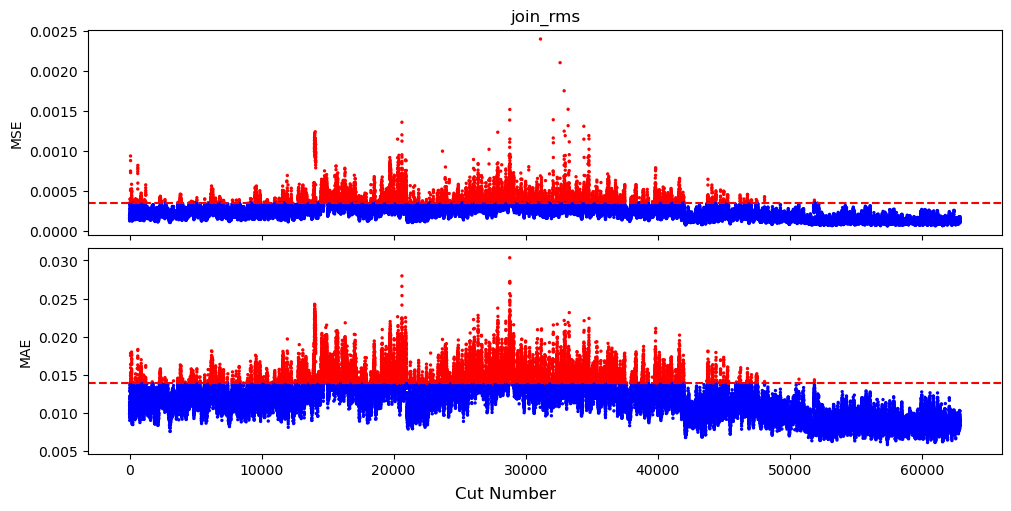

In [44]:
# metrics = ['mse', 'mae', 'r2']
metrics = ['mse', 'mae']

fig, ax = plt.subplots(len(metrics), len(exps),
                       figsize=(10, 5),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )
axes = fig.axes

for i, test in enumerate(exps):
    for j, met in enumerate(metrics):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        axes[(i)].set_title(test)
        axes[(len(exps) * j) + i].set_ylabel('')
        axes[(len(exps) * j) + i].set_xlabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')

_ = fig.supxlabel('Cut Number')

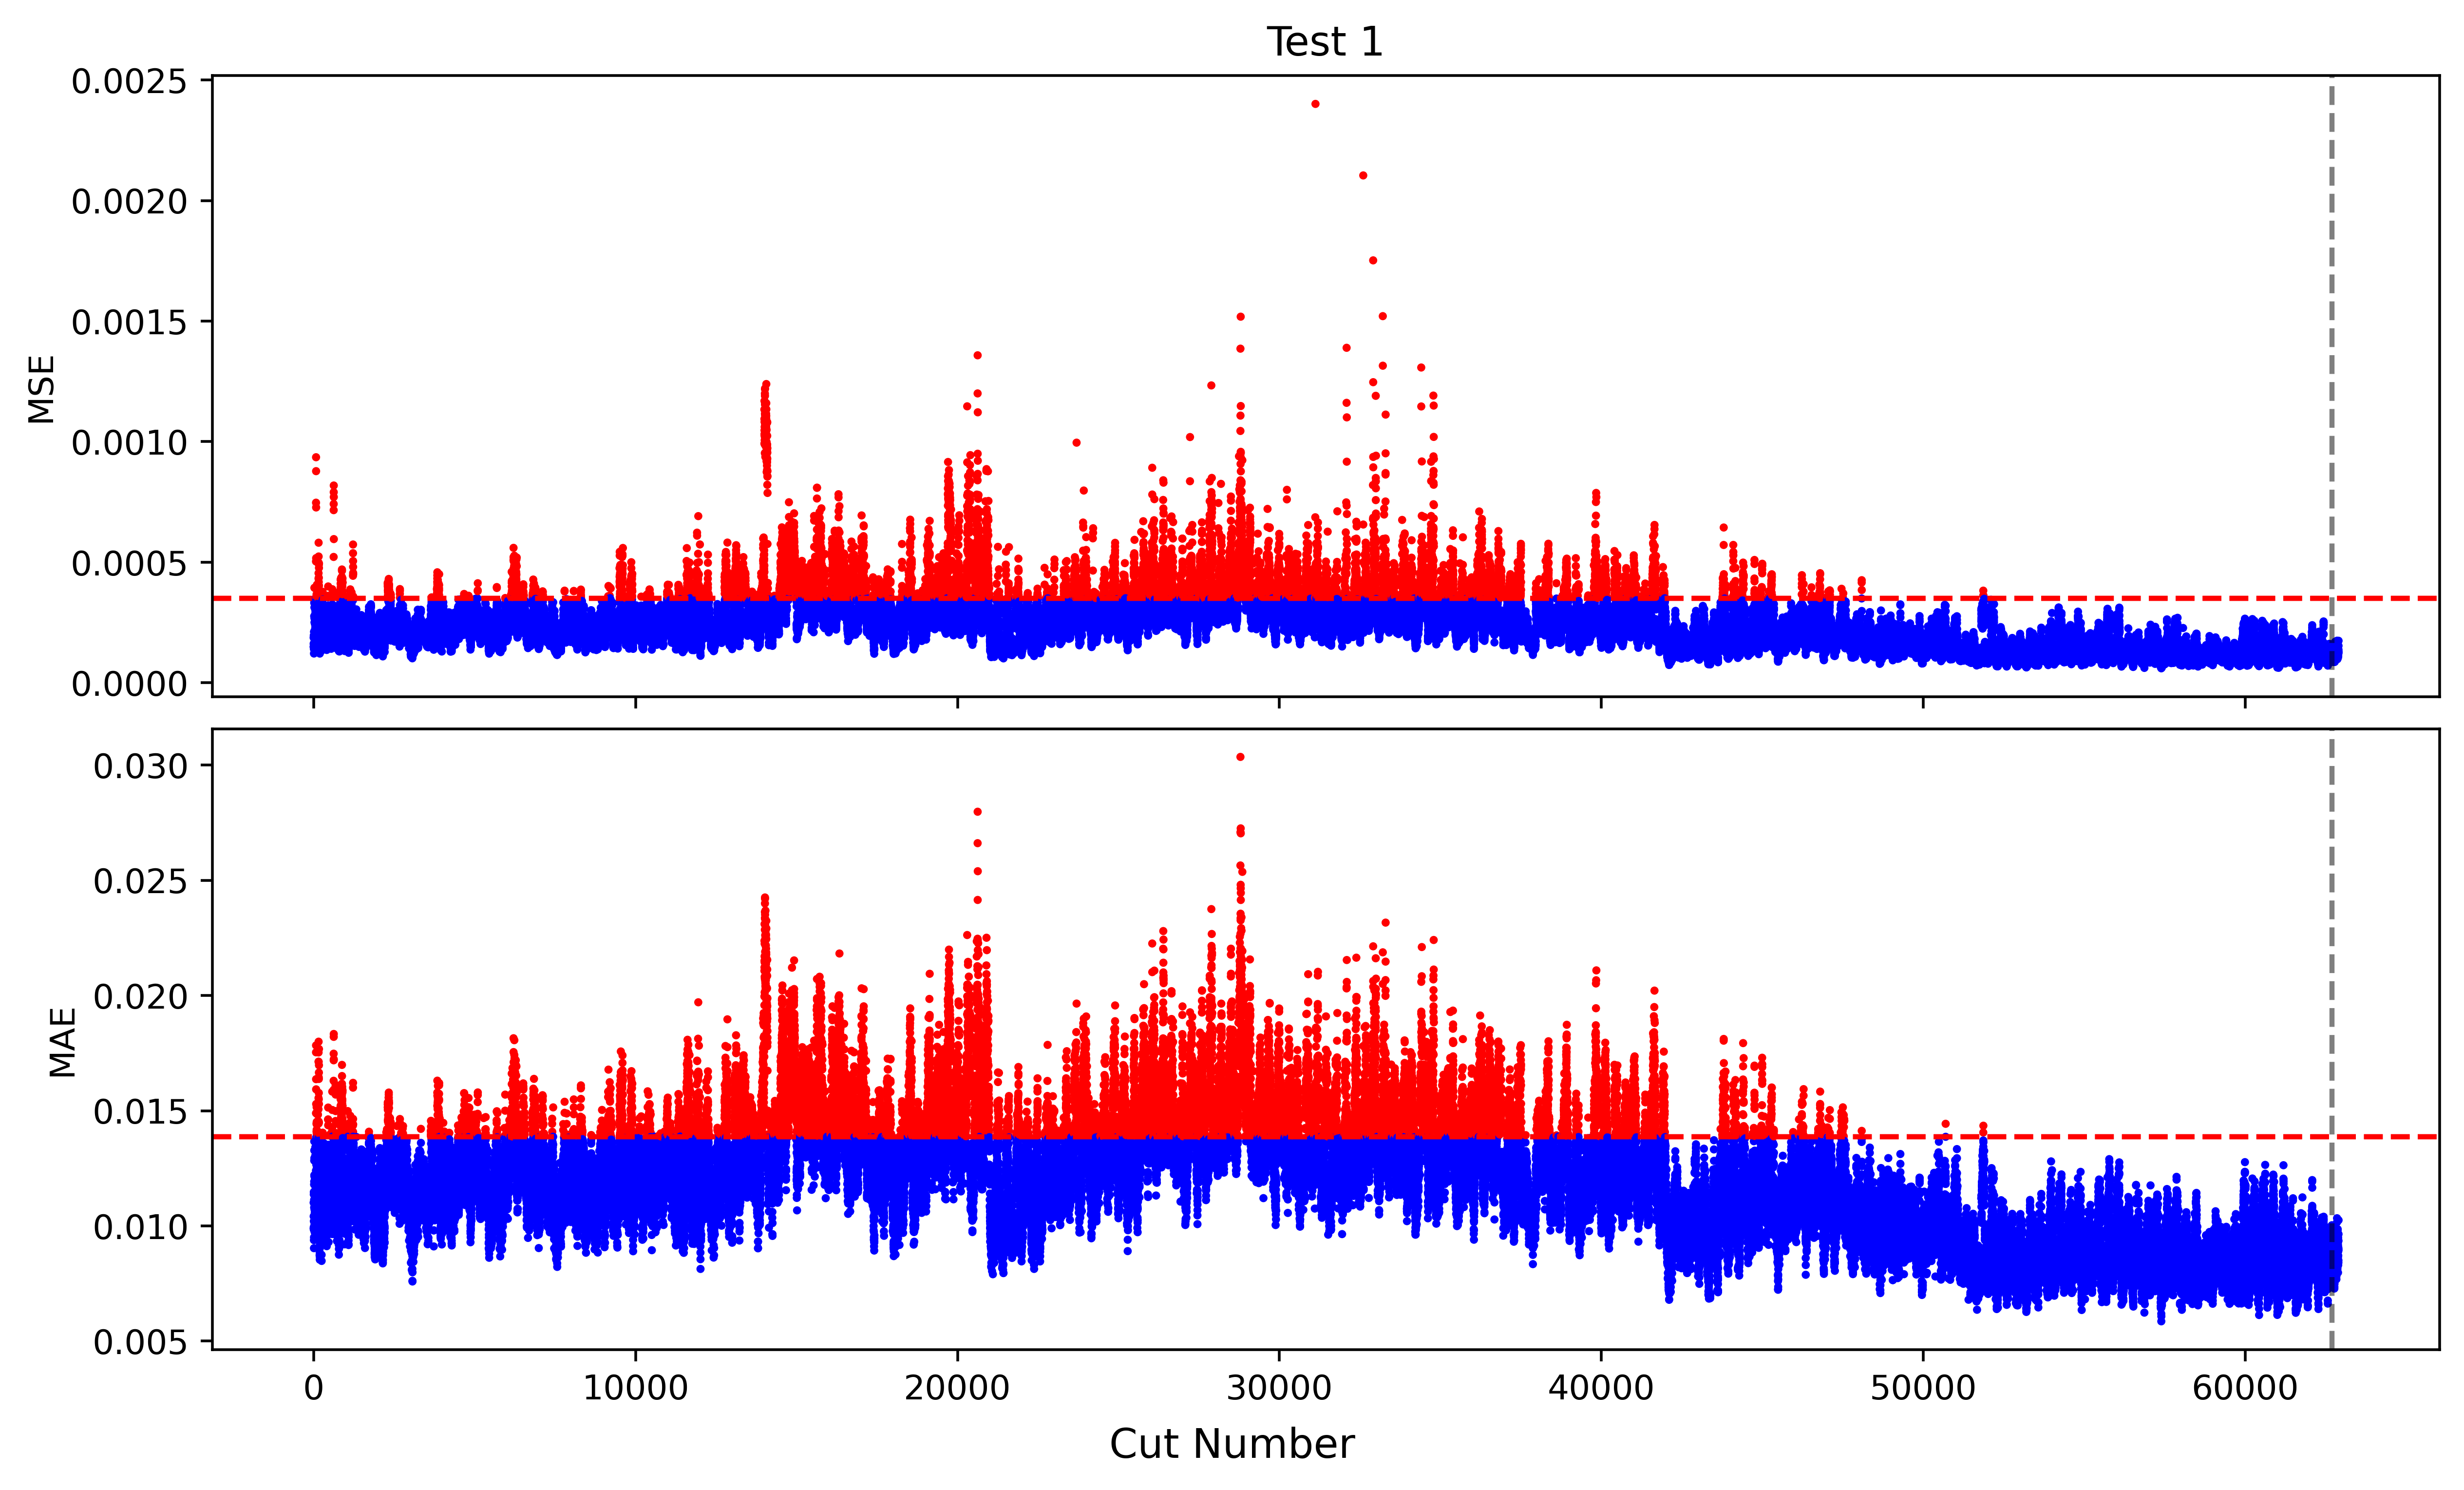

In [45]:
metrics = ['mse', 'mae']

fig, ax = plt.subplots(len(metrics), len(exps),
                       figsize=(10, 6),
                       constrained_layout=True,
                       sharex='col',
                       dpi=500
                       )
axes = fig.axes

for i, test in enumerate(exps):
    for j, met in enumerate(metrics):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])
        # score = autoe[test].scores[met]
        # axes[(i + (j * len(exps)))].scatter(x=range(len(score)),
        #                                     y=score,
        #                                     s=2,
        #                                     label=met,
        #                                     c='b'
        #                                     )

        axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop * 300,
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        axes[(i + (j * len(exps)))].axhline(autoe[test].thres[met], color='r', linestyle='--')

        axes[(i)].set_title(f'Test {i+ 1}')
        axes[(len(exps) * j) + i].set_ylabel('')
        axes[(len(exps) * j) + i].set_xlabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')

_ = fig.supxlabel('Cut Number')

In [46]:
dfs = [pd.DataFrame(autoe[test].scores) for test in exps]
df = pd.concat(dfs, keys=exps, names=['Test', 'Metrics'])
for test in exps:
    print(f'\n {test}')
    print(df.loc[test].describe())


 join_rms
                mae           mse            r2
count  62901.000000  62901.000000  62901.000000
mean       0.011976      0.000245      0.963791
std        0.002664      0.000118      0.016338
min        0.005859      0.000059      0.828875
25%        0.010018      0.000163      0.955218
50%        0.011864      0.000226      0.966857
75%        0.013662      0.000301      0.975386
max        0.030354      0.002401      0.994845


## autoe models latent space

In [47]:
# for test in exps:
#     fig, ax = autoe[test].plot_latent_space()

## Wear measurements comparison

NotADirectoryError: File location of join_rms not saved in load function. Known file locations are : dict_keys(['test1', 'test2', 'test5', 'test7', 'test8', 'test9', 'test10'])

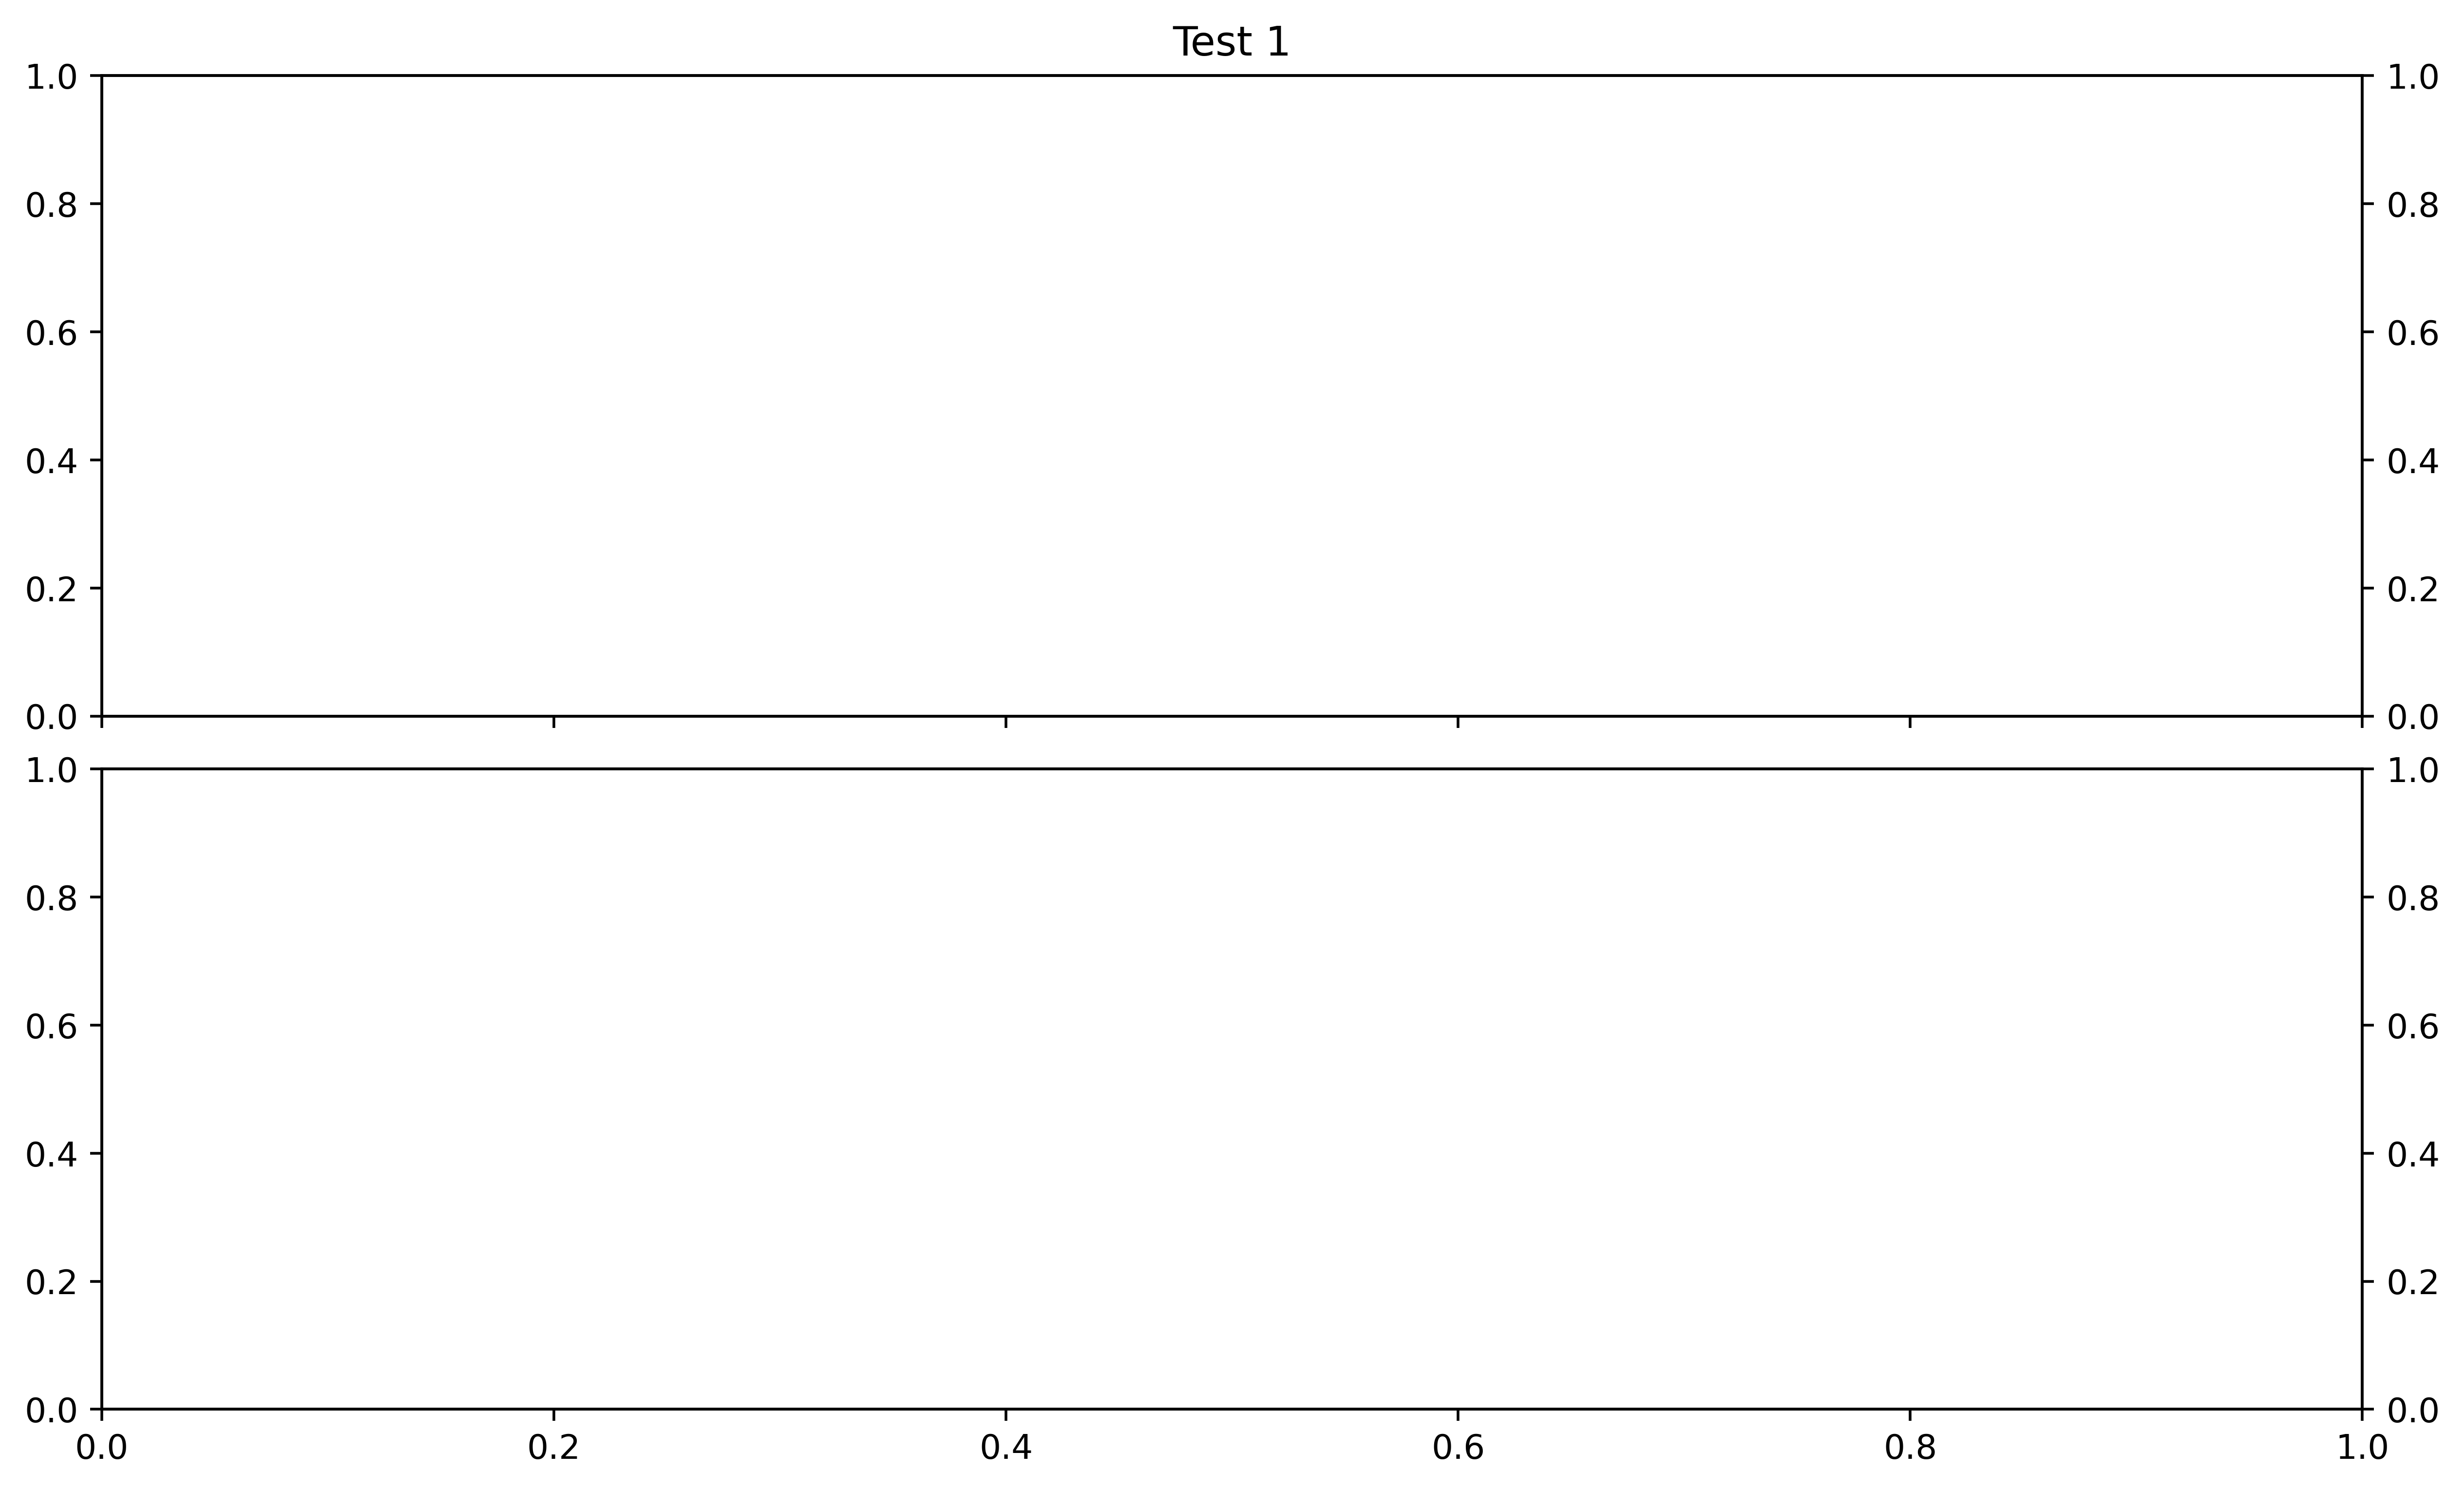

In [48]:
metric = ['mse', 'mae']
features = ['Runout', 'Form error']

fig, ax = plt.subplots(len(metric), len(exps),
                       figsize=(10, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       dpi=500,
                       )

ax2 = []

try:
    ax.ravel()
    for a in ax.ravel():
        ax2.append(a.twinx())
except AttributeError:
    ax2.append(ax.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

if len(metric) * len(exps) > 1:
    ax2 = np.reshape(ax2, ax.shape)

axes = fig.axes
axes2 = axes[-(len(axes) // 2):]
axes = axes[0:(len(axes) // 2)]
for i, test in enumerate(exps):
    axes[i].set_title(f'Test {i + 1}')
    # axes[i].set_title(test)

    exp = resources.load(test)
    for j, met in enumerate(metric):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        # vert line to show where training data ends
        axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop * 300,
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        for feature in features:
            feat = exp.features[feature].drop([0, 1, 2])
            if test == 'Test 5':
                feat = feat.drop([23, 24])
            # axes2[(len(exps) * j) + i].plot(range(len(feat)), feat, label=feature)
            axes2[(len(exps) * j) + i].plot(range(0, len(autoe[test].scores[met]), 300), feat, label=feature)

        axes[(len(exps) * j) + i].set_xlabel('')
        axes[(len(exps) * j) + i].set_ylabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')
        if i ==len(exps) - 1:
            axes2[(len(exps) * j) + i].set_ylabel('Errors')

_ = fig.supxlabel('Cut Number')

for i, a in enumerate(axes2):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = axes[0].get_legend_handles_labels()
l2, lab2 = axes2[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              ['Metric'] + lab2, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()

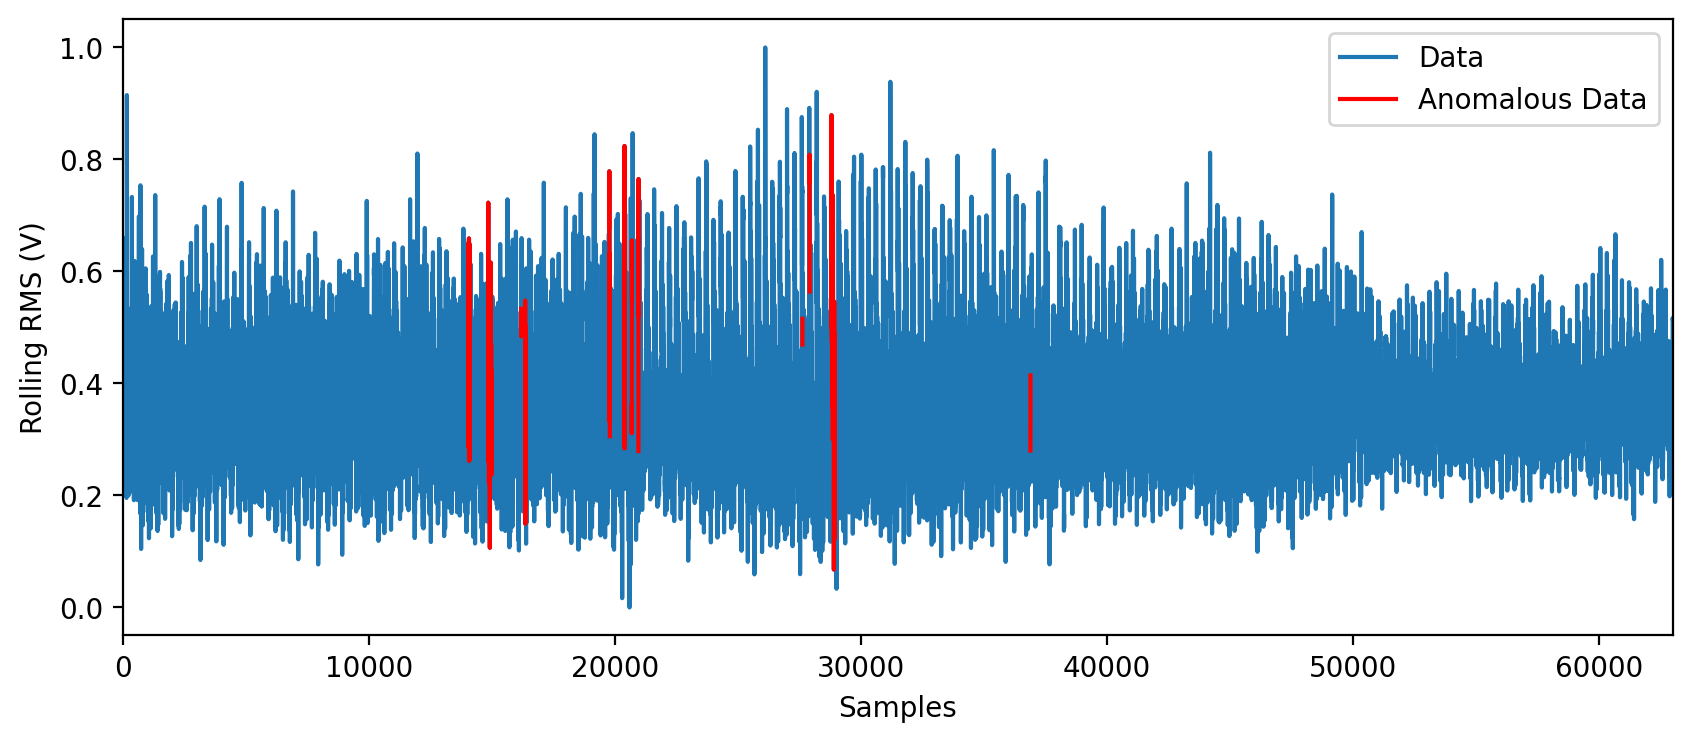

In [49]:
for test in exps:
    fig, ax = plt.subplots(figsize=(10, 4), dpi=200)
    try:
        autoe[test].anom_plot(anomaly_metric='mse', plt_ax=ax)
    except AttributeError:
        pass

0.0004262942702138539


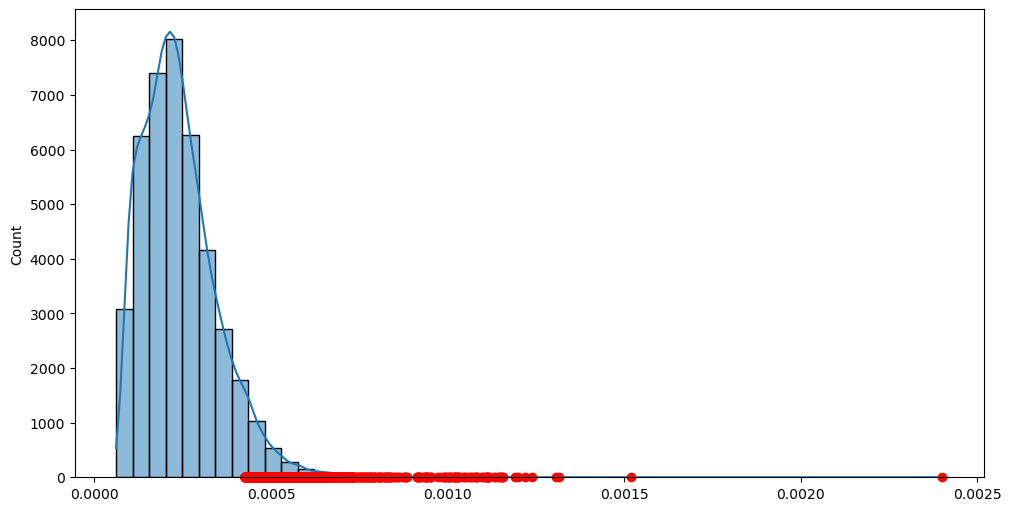

In [53]:
import seaborn as sns

fig, ax = plt.subplots(1, len(exps), figsize=(10,5), constrained_layout=True)
try:
    ax = ax.ravel()
except AttributeError:
    ax = [ax]

for i, test in enumerate(exps):
    a = autoe[test]
    sc = a.scores['mse'][a._ind_tr]

    def mad_based_outlier(points, thresh=2):
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

    outliers = sc[mad_based_outlier(sc)]
    print(np.min(outliers))

    sns.histplot(sc, ax=ax[i], kde=True, log_scale=False, bins=50)
    ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

# Try Transfer Learning

In [64]:
# First try the the model on the one used dataset and see how it performs
df_t9 = rms['Test 9'].data
jr_t9= []
for i in range(np.shape(df_t9)[1]):
    jr_t9.extend(df_t9.iloc[:, i].values.T)
jr_t9 = np.array(jr_t9).reshape(-1, 1)
print(f'Number of RMS samples: {np.shape(jr_t9)}')

assert ~np.isnan(jr_t9).any(), 'NaN values in RMS data'

# scale
jr_t9 = autoe['join_rms'].scaler.transform(jr_t9)

# sequence data
seq_t9 = autoe['join_rms'].sequence_inputs(jr_t9, autoe['join_rms'].seq_len)
print(f'Sequence data shape: {np.shape(seq_t9)}')

# predict
pred_t9 = autoe['join_rms'].model.predict(seq_t9)


Number of RMS samples: (46500, 1)
Sequence data shape: (46401, 100, 1)
726/726 [==============================] - 184s 253ms/step


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'MAE: 0.0332 MSE: 0.0017'}>)

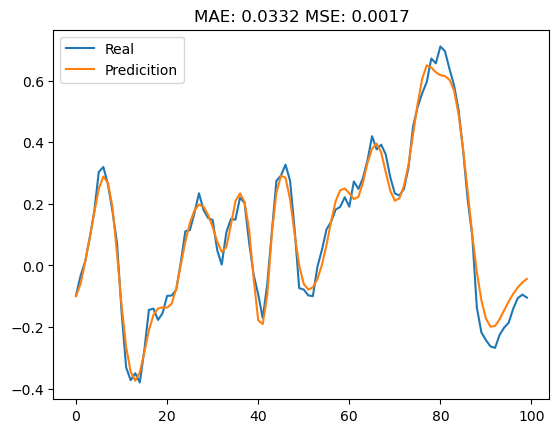

In [70]:
# score
i = 40000
autoe['join_rms'].pred_plot(i, input=(seq_t9, pred_t9))

In [77]:
(x, pred), scores = autoe['join_rms'].score(x=(seq_t9), tb=False)


Predicting data:
726/726 [==============================] - 181s 250ms/step

Scores:
	MAE: 0.01384
	MSE: 0.00059
	R2: 0.95461


/tmp/ipykernel_2572/3994960437.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


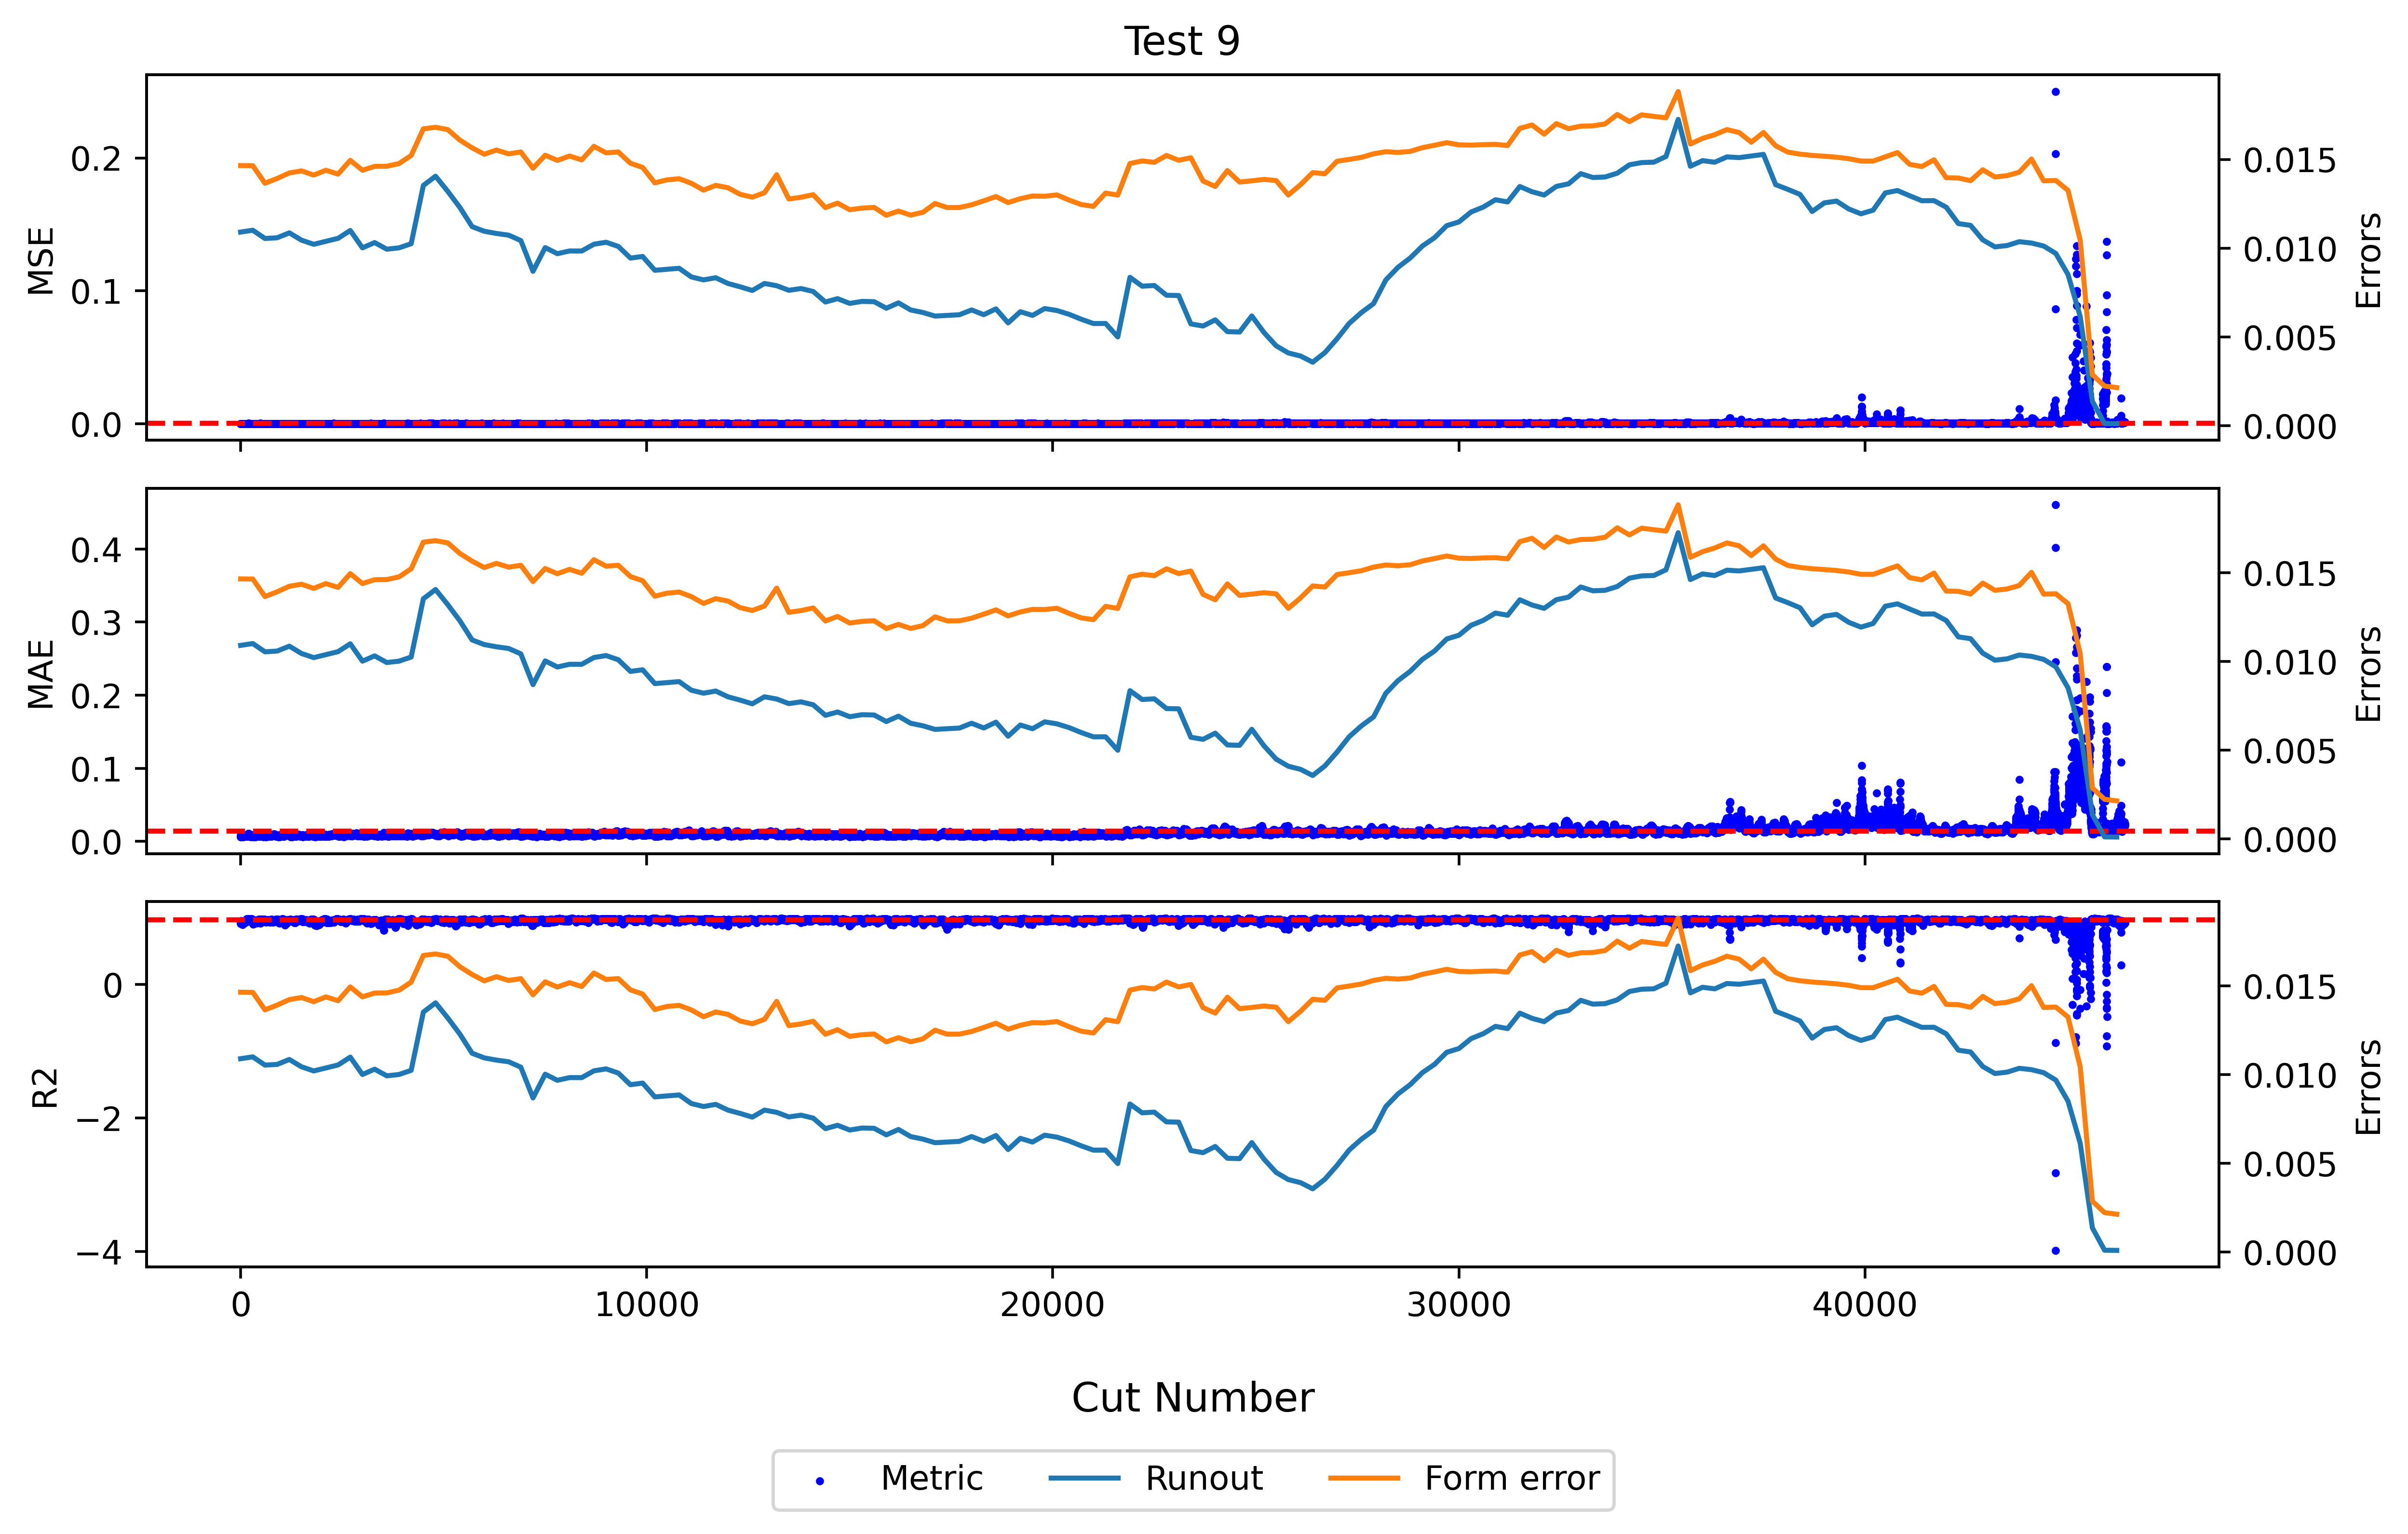

In [88]:
metric = ['mse', 'mae', 'r2']
features = ['Runout', 'Form error']

fig, ax = plt.subplots(len(metric), len(exps),
                       figsize=(10, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       dpi=500,
                       )

ax2 = []

try:
    ax.ravel()
    for a in ax.ravel():
        ax2.append(a.twinx())
except AttributeError:
    ax2.append(ax.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

if len(metric) * len(exps) > 1:
    ax2 = np.reshape(ax2, ax.shape)

axes = fig.axes
axes2 = axes[-(len(axes) // 2):]
axes = axes[0:(len(axes) // 2)]
for i, test in enumerate(['Test 9']):
    axes[i].set_title(test)

    exp = resources.load(test)
    for j, met in enumerate(metric):
        score = scores[met]
        axes[(i + (j * len(exps)))].scatter(x=range(len(score)),
                                            y=score,
                                            s=2,
                                            label=met,
                                            c='b'
                                            )

        axes[(i + (j * len(exps)))].axhline(autoe['join_rms'].thres[met], color='r', linestyle='--')

        # vert line to show where training data ends
        # axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop * 300,
        #                             color='k',
        #                             linestyle='--',
        #                             alpha=0.5,
        #                             )

        for feature in features:
            feat = exp.features[feature].drop([0, 1, 2])
            if test == 'Test 5':
                feat = feat.drop([23, 24])
            # axes2[(len(exps) * j) + i].plot(range(len(feat)), feat, label=feature)
            axes2[(len(exps) * j) + i].plot(range(0, len(scores[met]), 300), feat, label=feature)

        axes[(len(exps) * j) + i].set_xlabel('')
        axes[(len(exps) * j) + i].set_ylabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')
        if i ==len(exps) - 1:
            axes2[(len(exps) * j) + i].set_ylabel('Errors')

_ = fig.supxlabel('Cut Number')

for i, a in enumerate(axes2):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = axes[0].get_legend_handles_labels()
l2, lab2 = axes2[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              ['Metric'] + lab2, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()

In [90]:
# Then try transfer learning with the other dataset to see if the model requires less training to perform well
autoe_2 = LSTMAutoEncoder(rms['Test 9'],
                          rms['Test 9'].data,
                          tb=True,
                          tb_logdir='LSTMAE_test',
                          train_slice=(0, 50),
                          val_frac=0.33,
                          params={'epochs': 300,
                                  'batch_size': 64,
                                  'n_size': [256, 128, 64],
                                  'seq_len': 100,
                                  'n_bottleneck': 32,
                                  'loss': 'mean_squared_error',
                                  'callbacks': [
                                          tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=10,
                                            mode='min',
                                            start_from_epoch= 150,
                                            ),
                                     ]
                          }
                    )

Pre-processing Data:
	Combining RMS data...
	Number of RMS samples: (46500, 1)

	Training Data: slice(0, 50, None)
	Input train shape: (10050, 1)
	Input val shape: (4950, 1)

LSTMAE-Test_9-WIN-100-E-300-L-[256, 128, 64, 32, 64, 128, 256]-20230731-112733



In [91]:
name = autoe_2.run_name
model_folder = TB_DIR.joinpath(autoe_2._tb_logdir.joinpath(name))
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
assert os.path.exists(model_folder)

autoe_2.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
    filepath=model_folder.joinpath(f'{name}.h5'),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    )
)

autoe_2.model.initialize(X=autoe_2.train_data[0], y=autoe_2.train_data[0])

BaseWrapper(
	model=<function LSTMAutoEncoder._get_autoencoder at 0x7f232b919bd0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.adam.Adam object at 0x7f21a8aa1d20>
	loss=mean_squared_error
	metrics=['MSE', 'MAE', <function KerasRegressor.r_squared at 0x7f232bbccb80>]
	batch_size=64
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x7f1f680dc190>, <tensorflow_addons.callbacks.tqdm_progress_bar.TQDMProgressBar object at 0x7f21a8aa1a20>, <keras.callbacks.TensorBoard object at 0x7f21a8aa1db0>, <keras.callbacks.ModelCheckpoint object at 0x7f1f6814df60>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=300
	model__seq_len=100
	model__n_inputs=300
	model__n_bottleneck=32
	model__n_size=[256, 128, 64]
	model__activation=None
	model__activity_regularizer=None
)

In [92]:
name = autoe['join_rms'].run_name
model_folder = TB_DIR.joinpath(autoe['join_rms']._tb_logdir.joinpath(name))
autoe_2.model.model_.load_weights(
    TB_DIR.joinpath(model_folder.joinpath(f'{name}.h5'),),
)

In [93]:
autoe_2.fit(x=autoe_2.train_data,
            val_data=autoe_2.val_data,
            verbose=1,
            use_multiprocessing=True,
            )

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

Epoch 1/300
158/158 [==============================] - 142s 784ms/step - loss: 0.2942 - mean_squared_error: 0.2942 - mean_absolute_error: 0.3889 - r_squared: -138.6310 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1151 - val_r_squared: -0.3454
Epoch 2/300
158/158 [==============================] - 119s 757ms/step - loss: 0.0709 - mean_squared_error: 0.0709 - mean_absolute_error: 0.2078 - r_squared: -8.8743 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0940 - val_r_squared: 0.0423
Epoch 3/300
158/158 [==============================] - 120s 758ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.1424 - r_squared: -52.9918 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0923 - val_r_squared: 0.0588
Epoch 4/300
158/158 [==============================] - 120s 759ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1132 - r_squared: -1.2306 - 